# **The Math: Exponential vs Logistic**

### The spread of infectious disease can be modeled using a logistic curve rather than an exponential curve. The growth starts exponentially, but must slow down after some point called the **inflection point**. The inflection point is essentially the midpoint of the spread. We will model the number of confirmed cases using a logistic curve. Let's look at the equation for such a curve, the differential equation for which this curve is a solution, and the graph of the curve.

## Logistic Curve Graph

![LogCurve.png](attachment:LogCurve.png)

## Logistic Function

### A **logistic function** or **logistic curve** is an equation of the form: ![LogisticFunction.png](attachment:LogisticFunction.png)
### where

### * x_0 = the inflection point,
### * N = the curve's maximum value, and
### * k = growth rate or steepness of the curve.

### Actually, the logistic function is just a solution for the following first-order, non-linear ordinary differential equation where f(0) = 0.5: ![LogisticEquation.png](attachment:LogisticEquation.png)

### From the differential equation, stability of solutions and equilibria can be explored. However, let's keep things simple for now and just look at the growth metrics.


# **The Analysis**

### Now that we have seen the math, let's explore the following growth metrics for the confirmed cases for each country:
### * Growth Factor
### * Growth Ratio
### * Growth Rate
### * 2nd Derivative

### We will use these growth metrics to gain insight into which countries may have already hit their inflection points. For example, if a country's growth factor has stabilized around 1.0 then this can be a sign that that country has reached it's inflection point. We will then use curve fitting to fit a logistic curve (similar to the one above) to the number of confirmed cases for each country. This may help us predict if a country has hit their inflection point, and therefore when they will reach a possible maximum number of confirmed cases.

### **Interestingly, the growth factor just tells us the curvature (from Calculus!) of the data.** If we take our data and take the 2nd derivative, basically all it is telling us is whether the cases are growing at an accelerating or decelerating rate. From calculus you may remember we use the 2nd derivative test to test for concavity and find saddle points. The inflection point is where the curve changes concavity. We can look at these growth metrics

### The bigger picture will be to correlate this with preventative efforts such as quarentines, closing of schools, etc. It will also be interesting to see growth factor as a feature in a ML prediction model. I plan on working on this shortly.

## Import Data

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [30]:
global_data = pd.read_csv("/content/drive/My Drive/predictive_analysis_project/COLAB file/train.csv")
global_data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0




* Define Active Cases as Confirmed minus Recovered minus Deaths.
* Drop SNo, Province/State, and Last Update.
* Plot Active, Confirmed, and Recovered Cases, Deaths, Growth Factor, 2nd_Derivative, and Growth Ratio

The **growth factor** on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.

The **growth ratio** on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.



### Smoother Function

In [31]:

def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

Growth Factor

In [32]:

def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)

Growth Ratio

In [33]:
def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

In [34]:
# This is a function which plots (for in input country) the active, confirmed, and recovered cases, deaths, and the growth factor.
def plot_country_active_confirmed_recovered(country):
    
    # Plots Active, Confirmed, and Recovered Cases. Also plots deaths.
    country_data = global_data[global_data['Country_Region']==country]
    table = country_data.drop(['Id','Province_State'], axis=1)

    table2 = pd.pivot_table(table, values=['ConfirmedCases','Fatalities'], index=['Date'], aggfunc=np.sum)
    table3 = table2.drop(['Fatalities'], axis=1)
   
    # Growth Factor
    w = 0.5
    table2['GrowthFactor'] = growth_factor(table2['ConfirmedCases'])
    table2['GrowthFactor'] = smoother(table2['GrowthFactor'],w,5)

    # 2nd Derivative
    table2['2nd_Derivative'] = np.gradient(np.gradient(table2['ConfirmedCases'])) #2nd derivative
    table2['2nd_Derivative'] = smoother(table2['2nd_Derivative'],w,7)


    #Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['GrowthRatio'] = growth_ratio(table2['ConfirmedCases'])
    table2['GrowthRatio'] = smoother(table2['GrowthRatio'],w,5)
    
    #Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['GrowthRate']=np.gradient(np.log(table2['ConfirmedCases']))
    table2['GrowthRate'] = smoother(table2['GrowthRate'],0.5,3)
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]

    #plots
    table2['Fatalities'].plot(title='Fatalities')
    plt.show()
    table3.plot() 
    plt.show()
    table2['GrowthFactor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates) 
    plt.show()
    table2['2nd_Derivative'].plot(title='2nd_Derivative')
    plt.show()
    table2['GrowthRatio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    table2['GrowthRate'].plot(title='Growth Rate')
    plt.show()

    return 


## China

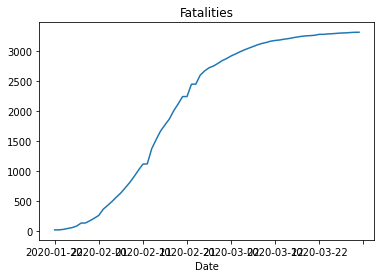

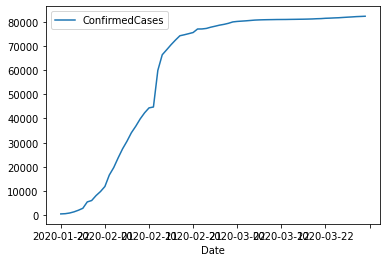

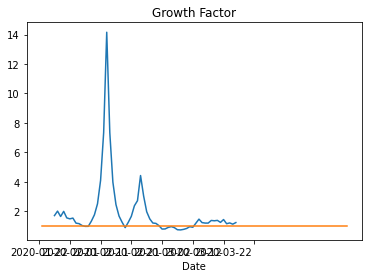

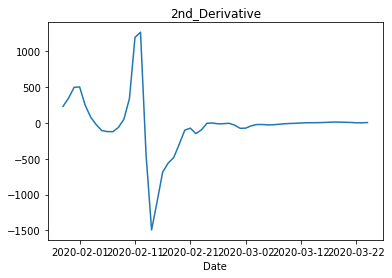

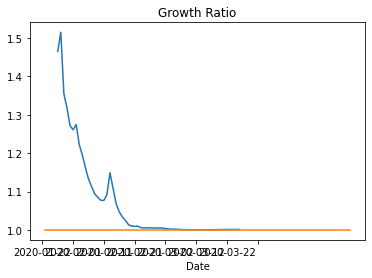

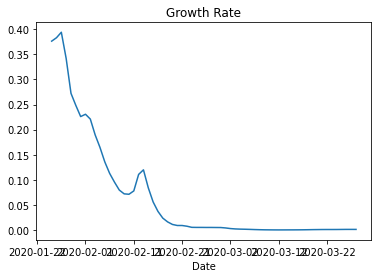

In [35]:
plot_country_active_confirmed_recovered('China') 

## US

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1057: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1078: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0


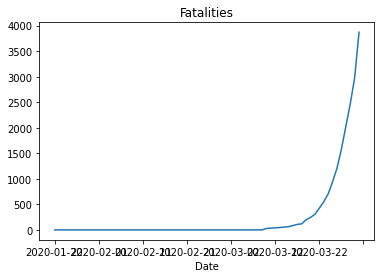

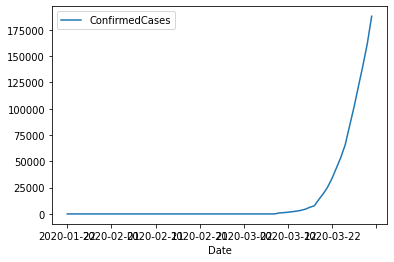

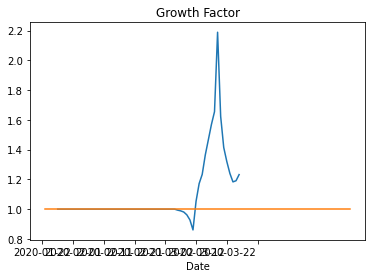

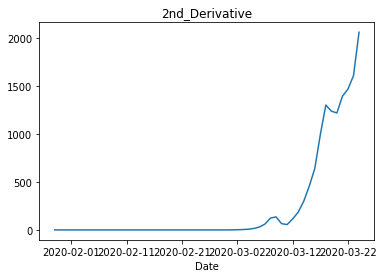

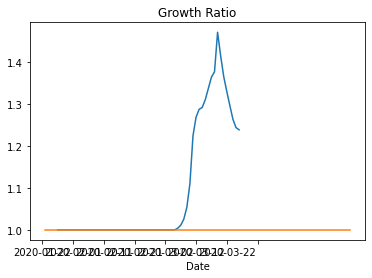

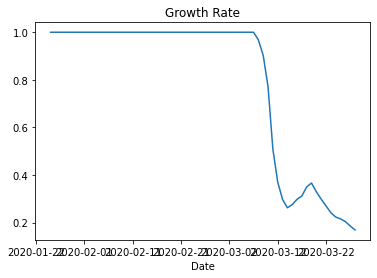

In [36]:
plot_country_active_confirmed_recovered('US')


## Germany

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1057: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1078: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0


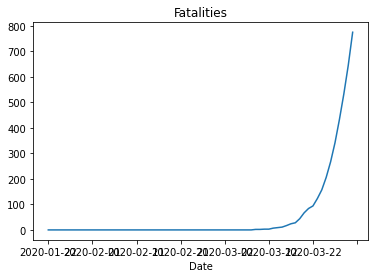

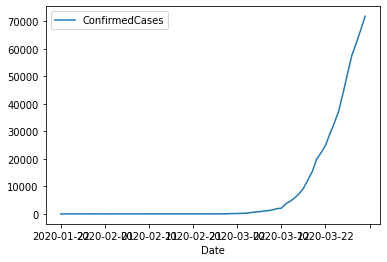

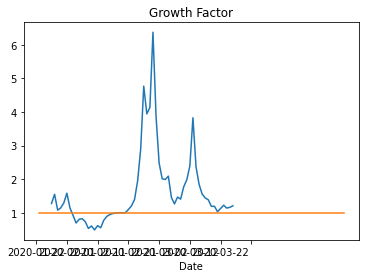

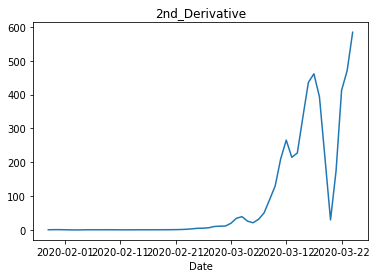

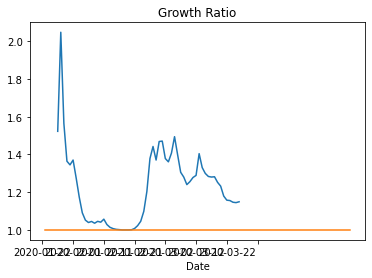

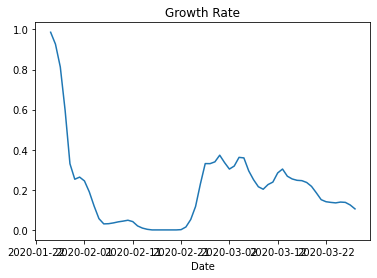

In [37]:
plot_country_active_confirmed_recovered('Germany')

## Italy

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1057: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1078: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0


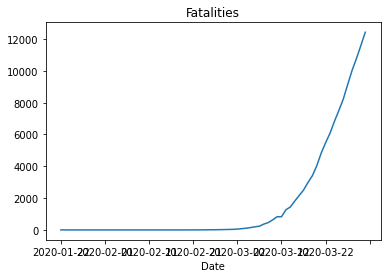

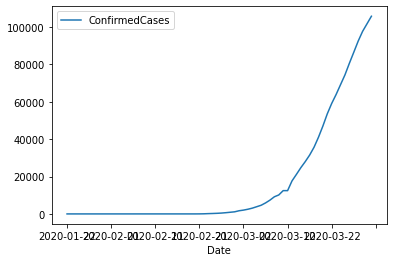

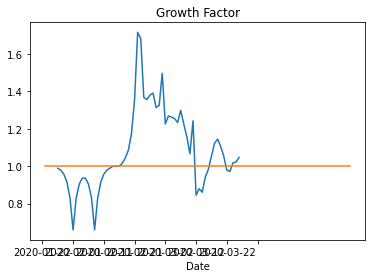

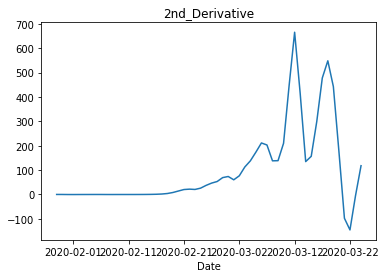

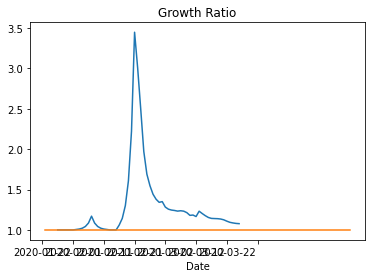

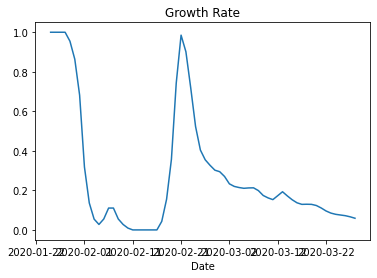

In [38]:
plot_country_active_confirmed_recovered('Italy')

Let's now compare China with the rest of the world.

## Rest of the World

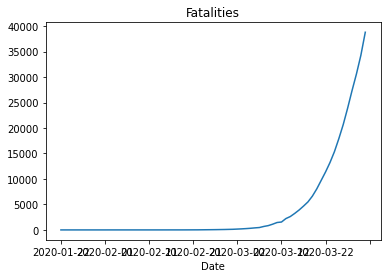

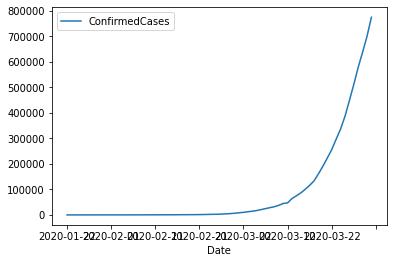

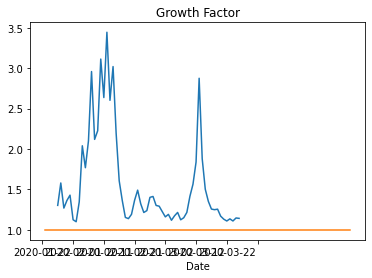

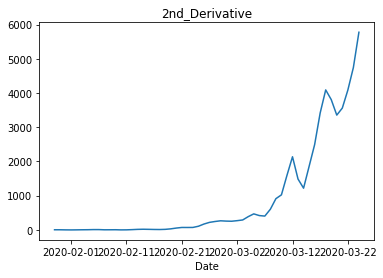

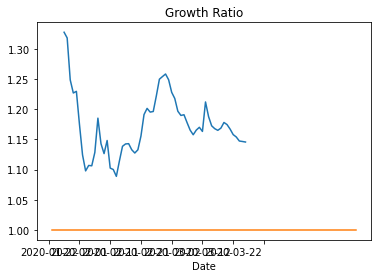

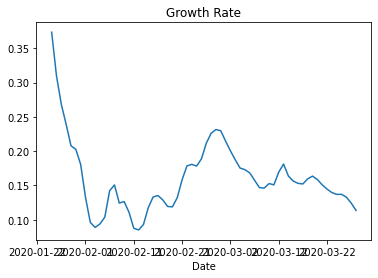

In [39]:
restofworld_data = global_data
for country in restofworld_data['Country_Region']:
    if country != 'China': 
        restofworld_data['Country_Region'] = restofworld_data['Country_Region'].replace(country, "RestOfWorld")

plot_country_active_confirmed_recovered('RestOfWorld')

## World data

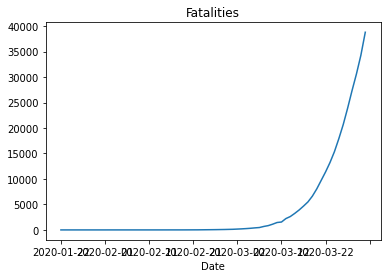

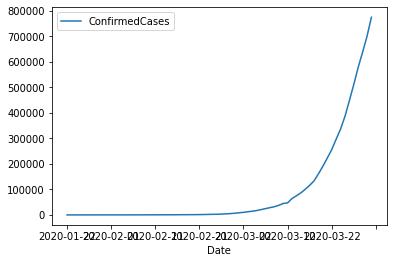

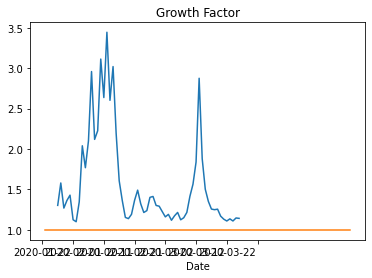

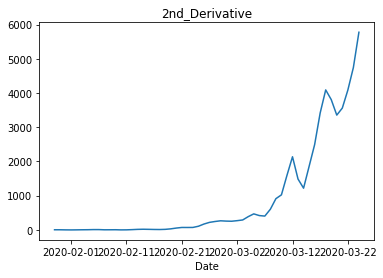

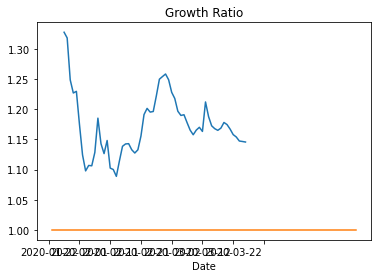

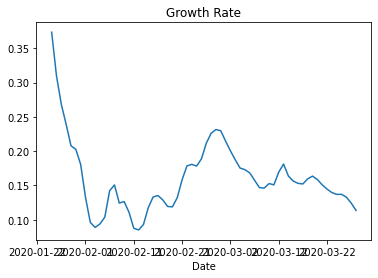

In [40]:
world_data = global_data

world_data['Country_Region'] = restofworld_data['Country_Region'].replace(country, "World Data")

plot_country_active_confirmed_recovered('World Data')

# **Logistic Curve Fitting**



In [41]:
from scipy.optimize import curve_fit

In [42]:
# We want number of confirmed for each date for each country

global_data = pd.read_csv("/content/drive/My Drive/predictive_analysis_project/COLAB file/train.csv")
country_data = global_data[global_data['Country_Region']=='Italy']
country_data = country_data.drop(['Id','Province_State'], axis=1)
country_data = pd.pivot_table(country_data, values=['ConfirmedCases','Fatalities'], index=['Date'], aggfunc=np.sum)
country_data.tail()

,ConfirmedCases,Fatalities
Date,,
2020-03-27,86498.0,9134.0
2020-03-28,92472.0,10023.0
2020-03-29,97689.0,10779.0
2020-03-30,101739.0,11591.0
2020-03-31,105792.0,12428.0


In [46]:

# we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
x_data = range(len(country_data.index))
y_data = country_data['ConfirmedCases']

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=1000)
estimated_k, estimated_x_0, ymax= popt


# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(x_data, k, x_0, ymax)
print(k, x_0, ymax)




476.80926439359973 33.93198268108148 33625.36537243225


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [45]:
#print(y_fitted)
y_data.tail()

Date
2020-03-27     86498.0
2020-03-28     92472.0
2020-03-29     97689.0
2020-03-30    101739.0
2020-03-31    105792.0
Name: ConfirmedCases, dtype: float64

In [1]:
y_data

NameError: ignored

### Notice that this predicts Italy hits the inflection point is around day 51 and the number of confirmed cases will max out around 119,874 cases.

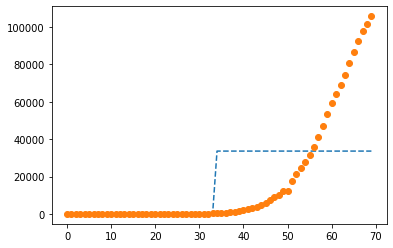

In [44]:
# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')
